# Prostate Cancer
The data for this example come from a study by Stamey et al. (1989) that examined the correlation between the level of prostate specific antigen (PSA) and a number of clinical measures, in 97 men who were about to receive a radical prostatectomy.
The goal is to predict the log of PSA (lpsa) from a number of measurements.

Variables:

|         |                                                       |
|---------|-------------------------------------------------------|
|lpsa     |log prostate specific antigen                          |
|lcavol   |log cancer volume                                      |
|lweight  |log prostate weight                                    |
|age      |age                                                    |
|lbph     |log of benign prostatic hyperplasia amount             |
|svi      |seminal vesicle invasion                               |
|lcp      |log of capsular penetration                            |
|gleason  |Gleason score                                          |
|pgg45    |percent of Gleason scores 4 or 5                       |

This is a supervised learning problem, known as a regression problem, because the outcome measurement is quantitative.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
from typing import Union, List
%matplotlib inline

# set common plots properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
ORANGE, BLUE, PURPLE = '#E69F00', '#56B4E9', '#A020F0'
GRAY1, GRAY4 = '#231F20', '#646369'

# turn off numpy warings
np.warnings.filterwarnings('ignore')

## Load and Prepare Data

In [2]:
# we will predict lpsa (log prostate specific antigen)
target = 'lpsa'
# based on the following features
features = ['lcavol', 'lweight', 'age', 'lbph',
            'svi', 'lcp', 'gleason', 'pgg45']
# load training and test data from the file
df = pd.read_csv("../data/Prostate Cancer.txt")
df.head()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


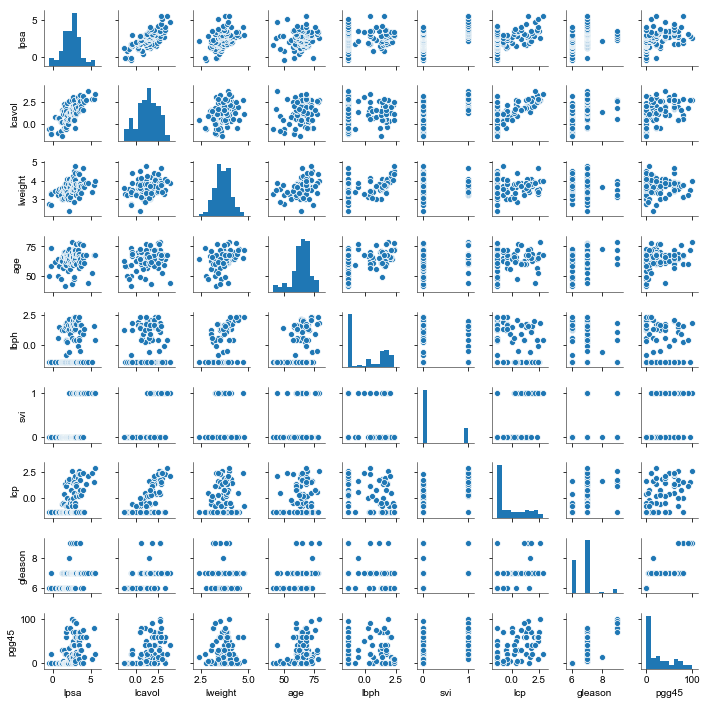

In [3]:
# PAGE 3. FIGURE 1.1. Scatterplot matrix of the prostate cancer data. The first
#         row shows the response against each of the predictors in turn. Two of
#         the predictors, svi and gleason, are categorical.
#         Some correlations with lpsa are evident, but a good predictive model
#         is difficult to construct by eye.
sns.pairplot(df, vars=[target]+features, kind="scatter", height=1.1)

In [4]:
# split data into training/test sets based on the train flag
is_train = df.train == 'T'
X, y = df[features].values, df[target].values
X_train, y_train = X[is_train], y[is_train]
X_test, y_test = X[~is_train], y[~is_train]

In [5]:
# PAGE 49. The correlation matrix of the predictors given in Table 3.1 shows
#          many strong correlations. Figure 1.1 (page 3) of Chapter 1 is a
#          scatterplot matrix showing every pairwise plot between the
#          variables. We see that svi is a binary variable, and gleason is an
#          ordered categorical variable. We see, for example, that both lcavol
#          and lcp show a strong relationship with the response lpsa, and with
#          each other. We need to fit the effects jointly to untangle the
#          relationships between the predictors and the response.
df[is_train][features].corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


## Base Error Rate

In [6]:
from sklearn.dummy import DummyRegressor
# PAGE 51. prediction using the mean training value of lpsa has a test error of
#          1.057, which is called the "base error rate".
null_model = DummyRegressor().fit(X_train, y_train)
base_error_rate = mean_squared_error(y_test, null_model.predict(X_test))
print(f'Baseline Test Error: {base_error_rate:.3f}')

Baseline Test Error: 1.057


## Least Squares

In [7]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [8]:
# PAGE 50. We fit a linear model to the log of prostate-specific antigen, lpsa,
#          after first standardizing the predictors to have unit variance.
scaler = StandardScaler().fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# PAGE 50. We applied least squares estimation to the training set, producing
#          the estimates, standard errors and Z-scores shown in Table 3.2.
ls = sm.OLS(y_train, sm.add_constant(X_train)).fit()
ls_params = ls.params

# PAGE 50. TABLE 3.2. Linear model fit to the prostate cancer data. The Z
#          score (t value) is the coefficient divided by its standard error
#          (3.12). Roughly Z score larger than two in absolute value is
#          significantly nonzero at the p = 0.05 level.
result = zip(['Intercept'] + features, ls_params, ls.bse, ls.tvalues)
print('      Term   Coefficient   Std. Error   Z Score')
print('-----------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>10}{coefficient:>14.2f}{std_err:>13.2f}{z_score:>10.2f}')

      Term   Coefficient   Std. Error   Z Score
-----------------------------------------------
 Intercept          2.46         0.09     27.60
    lcavol          0.68         0.13      5.37
   lweight          0.26         0.10      2.75
       age         -0.14         0.10     -1.40
      lbph          0.21         0.10      2.06
       svi          0.30         0.12      2.47
       lcp         -0.29         0.15     -1.87
   gleason         -0.02         0.14     -0.15
     pgg45          0.27         0.15      1.74


In [10]:
# PAGE 51. The mean prediction error on the test data is 0.521.
y_hat = ls.predict(sm.add_constant(X_test))
ls_error_rate = mean_squared_error(y_test, y_hat)
ls_std_error = np.std((y_test - y_hat)**2, ddof=1)/np.sqrt(y_test.size)
print(f'Least Squares Test Error: {ls_error_rate:.3f}')
print(f'               Std Error: {ls_std_error:.3f}')

Least Squares Test Error: 0.521
               Std Error: 0.179


## Cross-Validation
All linear models for this example in the book are selected using the same approach based on "one-standard-error-rule":
1.  For each parameter value, perform K-fold cross-validation.
2.  Calculate the cross-validation mean MSE and its standard error.
3.  Find the best model, its cross-validation mean MSE and its standard error.
4.  Find the least complex model with cross-validation mean MSE within one standard error of the best.

Let's implement a class that takes 1-4 steps and stores all the information needed for plotting.

In [11]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression

In [12]:
class OneStandardErrorRuleModel:
    """Select the least complex model within one standard error of the best.
    Parameters
    ----------
        estimator :
            A regression or a classification model to be parametrized.
        param_name :
            The parameter of the model to be chosen by cross-validation.
        param_values :
            The values for the parameter in order of increasing complexity.
        force_model_idx :
            The preselected model index. Sometimes it is useful to run the
            process but to select the specified in advance model.
        n_folds :
            The number of folds for cross-validation.
        is_regression :
            True for a regression model, False for a classification model.
        random_state :
            The seed of the pseudo random number generator.
    Attributes
    ----------
        cv_mean_errors_ :
            Mean CV error for each parameter value.
        cv_mean_errors_std_ :
            Standard error of mean CV error for each parameter value.
        best_model_idx_ :
            The index of the param_values on which minimal mean error achieved.
        cv_min_error_ :
            Mean CV error for the best param_values.
        cv_min_error_std_ :
            Standard error of mean CV error for the best param_values.
        model_idx_ :
            The index of the model selected by "one standard error rule".
        model_ :
            The regression model retrained with selected parameter.
    """
    def __init__(self, estimator, param_name: str, param_values: List[float],
                 force_model_idx: int=None, n_folds: int=10,
                 is_regression: bool=True, random_state: int=69438):
        self.n_folds = n_folds
        self.estimator = estimator
        self.param_name = param_name
        self.param_values = param_values
        self.force_model_idx = force_model_idx
        self.is_regression = is_regression
        # neg_mean_squared_error for regression and accuracy for classification
        self.grid_search = GridSearchCV(
            estimator, {param_name: param_values},
            cv=KFold(n_folds, True, random_state),
            scoring='neg_mean_squared_error' if is_regression else 'accuracy',
            return_train_score=True, iid=True)

    def fit(self, X: np.ndarray, y: np.array) -> 'OneStandardErrorRuleModel':
        self.grid_search.fit(X, y)
        # convert score to mean squared error for regression and to error rate
        # for classification
        cv_errors = -np.vstack(
            [self.grid_search.cv_results_[f'split{i}_test_score']
             for i in range(self.n_folds)]).T
        if not self.is_regression:
            cv_errors = 1 + cv_errors
        # calculate mean error for parameters and their standard error
        self.cv_mean_errors_ = np.mean(cv_errors, axis=1)
        self.cv_mean_errors_std_ = \
            np.std(cv_errors, ddof=1, axis=1) / np.sqrt(self.n_folds)

        # find the best model
        self.best_model_idx_ = np.argmin(self.cv_mean_errors_)
        self.cv_min_error_ = self.cv_mean_errors_[self.best_model_idx_]
        self.cv_min_error_std_ = self.cv_mean_errors_std_[self.best_model_idx_]
        # find the least complex model within one standard error of the best
        error_threshold = self.cv_min_error_ + self.cv_min_error_std_
        self.model_idx_ = np.argmax(self.cv_mean_errors_ < error_threshold)
        return self.__fit_to_all_data(X, y)

    def refit(self, X: np.ndarray, y: np.array,
              force_model_idx: int=None) -> 'OneStandardErrorRuleModel':
        self.force_model_idx = force_model_idx
        return self.__fit_to_all_data(X, y)

    def __fit_to_all_data(self, X, y):
        if self.force_model_idx is not None:
            self.model_idx_ = self.force_model_idx
        self.model_ = self.estimator
        self.model_.set_params(
            **{self.param_name: self.param_values[self.model_idx_]})
        self.model_.fit(X, y)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.squeeze(self.model_.predict(X))

    def assess(self, X: np.ndarray, y: np.array) -> (float, float):
        """Calculate mean error of the model and its standard error on the
           specified data."""
        y_hat = self.predict(X)
        errors = (y-y_hat)**2 if self.is_regression else 1.0*(y != y_hat)
        error = np.mean(errors)
        error_std = np.std(errors, ddof=1) / np.sqrt(y.size)
        return error, error_std

In [13]:
# linear zero-complexity model is the model that predicts the mean target value
# let's run our class in order to find it's mean CV error and its standard
# error this information will be used in plotting
baseline = OneStandardErrorRuleModel(
    DummyRegressor(), 'constant', [None]
).fit(X_train, y_train)

In [14]:
# plots the model selection results, "complexities" could contain x axis ticks
# for example, Ridge regression is regularized by "alpha" parameter, but
# it is assumed that we regularize the "degrees of freedom"
def plot_cv_results(title, x_label, model, complexities: List[float] = None):
    if complexities is None:
        complexities = model.param_values
    complexities = [0] + complexities
    means = np.hstack((baseline.cv_mean_errors_, model.cv_mean_errors_))
    stds = np.hstack((baseline.cv_mean_errors_std_, model.cv_mean_errors_std_))
    fig, ax = plt.subplots(figsize=(4, 3.1), dpi=110)
    ax.plot(complexities, means, c=ORANGE, linewidth=0.8)
    ax.errorbar(
        complexities, means, color=ORANGE, linestyle='None', marker='o',
        elinewidth=0.8, markersize=3, yerr=stds, ecolor=BLUE, capsize=3)
    ax.axhline(y=model.cv_min_error_ + model.cv_min_error_std_,
               c=PURPLE, linewidth=0.8, linestyle='--')
    ax.axvline(x=complexities[model.model_idx_ + 1],
               c=PURPLE, linewidth=0.8, linestyle='--')
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(6)
    ax.text(ax.get_xlim()[0], 1.85, title, color=GRAY4, fontsize=9)
    ax.set_xlabel(x_label, color=GRAY4, fontsize=8)
    ax.set_ylabel('CV Error', color=GRAY4, fontsize=8)
    parms = {'color': GRAY1, 'fontsize': 7,
             'bbox': {'facecolor': 'white', 'pad': 0, 'edgecolor': 'none'}}
    lim = ax.get_xlim()
    text_x = lim[1] - (lim[1]-lim[0])*0.02
    test_error, test_error_std = model.assess(X_test, y_test)
    ax.text(text_x, 1.72, f'Test Error:  {test_error:.3f}',
            **parms, ha='right')
    ax.text(text_x, 1.63, f' Std Error:  {test_error_std:.3f}',
            **parms, ha='right')

## Ridge Regression

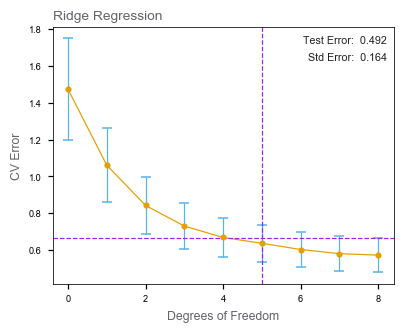

In [15]:
# PAGE 61. Ridge regression shrinks the regression coefficients by imposing a
#          penalty on their size. The ridge coefficients minimize a penalized
#          residual sum of squares, (3.41) Here λ ≥ 0 is a complexity parameter
#          that controls the amount of shrinkage: the larger the value of λ,
#          the greater the amount of shrinkage. The coefficients are shrunk
#          toward zero (and each other). The idea of penalizing by the
#          sum-of-squares of the parameters is also used in neural networks,
#          where it is known as weight decay (Chapter 11).

# these alpha parameters correspond to 1-8 degrees of freedom
ridge_regression = OneStandardErrorRuleModel(
    Ridge(), 'alpha', [436, 165, 82, 44, 27, 12, 4, 1e-05]
).fit(X_train, y_train)
# save model parameters as 1D vector
ridge_params = np.hstack((ridge_regression.model_.intercept_,
                          ridge_regression.model_.coef_))
plot_cv_results('Ridge Regression', 'Degrees of Freedom',
                ridge_regression, list(range(1, 9)))

## Lasso Regression

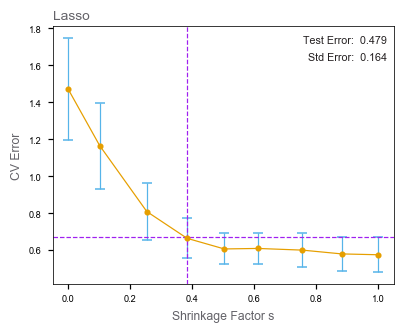

In [16]:
# PAGE 68. The lasso is a shrinkage method like ridge, with subtle but
#          important differences. The lasso estimate is defined by (3.51).

# these alpha parameters correspond to below shrinkage values
lasso_regression = OneStandardErrorRuleModel(
    Lasso(), 'alpha',
    [0.680, 0.380, 0.209, 0.100, 0.044, 0.027, 0.012, 0.001]
).fit(X_train, y_train)
# save model parameters as 1D vector
lasso_params = np.hstack((lasso_regression.model_.intercept_,
                          lasso_regression.model_.coef_))
plot_cv_results('Lasso', 'Shrinkage Factor s', lasso_regression,
                [0.102, 0.254, 0.384, 0.504, 0.612, 0.756, 0.883, 1])

## Principal Components Regression

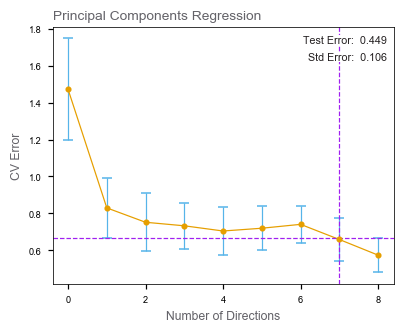

In [17]:
# PAGE 79. In this approach the linear combinations Zm used are the principal
#          components as defined in Section 3.4.1 above.
model = Pipeline([('pca', PCA()),
                  ('regression', LinearRegression())])
pca_regression = OneStandardErrorRuleModel(
    model, 'pca__n_components', list(range(1, 9))
).fit(X_train, y_train)
# X_train is not centered, so we need to calculate coefficients
pca, lr = pca_regression.model_['pca'], pca_regression.model_['regression']
pca_params = np.zeros(8)
intercept = lr.intercept_
for i in range(7):
    pca_params += lr.coef_[i]*pca.components_[i, :]
    intercept -= lr.coef_[i]*(pca.mean_ @ pca.components_[i, :])
# the parameters are different from the book, but are correct
pca_params = np.hstack(([intercept], pca_params))
plot_cv_results('Principal Components Regression', 'Number of Directions',
                pca_regression)

## Partial Least Squares

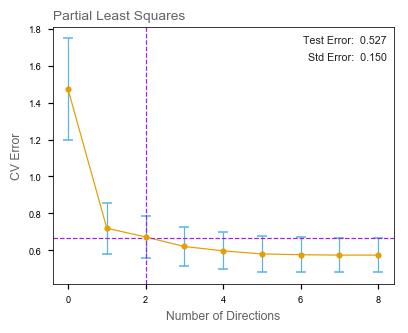

In [18]:
# PAGE 80. This technique also constructs a set of linear combinations of the
#          inputs for regression, but unlike principal components regression it
#          uses y (in addition to X) for this construction.

# out cross-validation gives 3 components, but let's pretend that the result is
# n = 2 components to be consistent with the book
pls_regression = OneStandardErrorRuleModel(
    PLSRegression(scale=False), 'n_components', list(range(1, 9)),
    force_model_idx=1
).fit(X_train, y_train)
# save model parameters as 1D vector
pls_params = np.hstack((pls_regression.model_.y_mean_,
                       np.squeeze(pls_regression.model_.coef_)))
plot_cv_results('Partial Least Squares', 'Number of Directions',
                pls_regression)

## Best Subset Regression
Scikit-Learn does not implement the best subset regression model, so let's implement it ourselves. It is derived from the linear regression class and therefore can be used in standard Scikit-learn pipelines and cross-validation.

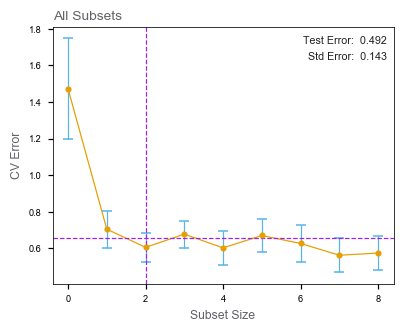

In [19]:
from itertools import combinations


class BestSubsetRegression(LinearRegression):
    """Linear regression based on the best features subset of fixed size.
    Parameters
    ----------
        subset_size :
            The number of features in the subset.
    """
    def __init__(self, subset_size: int = 1):
        LinearRegression.__init__(self)
        self.subset_size = subset_size

    def fit(self, X: np.ndarray, y: np.array,
            sample_weight: np.array=None) -> ' BestSubsetRegression':
        best_combination, best_mse = None, np.inf
        best_intercept_, best_coef_ = None, None
        # try all combinations of subset_size
        for combination in combinations(range(X.shape[1]), self.subset_size):
            X_subset = X[:, combination]
            LinearRegression.fit(self, X_subset, y)
            mse = mean_squared_error(y, self.predict(X_subset))
            if best_mse > mse:
                # select the best combination
                best_combination, best_mse = combination, mse
                best_intercept_, best_coef_ = self.intercept_, self.coef_
        LinearRegression.fit(self, X, y)
        # replace intercept and parameters with the found, set other zero
        self.intercept_ = best_intercept_
        self.coef_[:] = 0
        self.coef_[list(best_combination)] = best_coef_
        return self

bs_regression = OneStandardErrorRuleModel(
    BestSubsetRegression(), 'subset_size', list(range(1, 9))
).fit(X_train, y_train)
# save model parameters as 1D vector
bs_params = np.hstack((bs_regression.model_.intercept_,
                       bs_regression.model_.coef_))
plot_cv_results('All Subsets', 'Subset Size', bs_regression)

## Summary (TABLE 3.3)

In [20]:
# PAGE 63. TABLE 3.3. Estimated coefficients and test error results, for
#          different subset and shrinkage methods applied to the prostate date.
#          The blank entries correspond to variables omitted.
# NOTE: The result is very close to the values in the table of the book.
#       However, there are differences. In most cases, in the second and third
#       decimal places. Perhaps the implementation of the algorithms in R and
#       sklearn are slightly different. Test errors and standard test errors
#       are almost identical.
params = zip(['Intercept'] + features, ls_params, bs_params, ridge_params,
             lasso_params, pca_params, pls_params)
print('      Term       LS   Best Subset    Ridge    Lasso      PCR      PLS')
print('---------------------------------------------------------------------')
for term, ls, bs, rd, lo, pc, ps in params:
    print(f'{term:>10}{ls:>9.3f}{bs:>14.3f}{rd:>9.3f}{lo:>9.3f}{pc:>9.3f}'
          f'{ps:>9.3f}')
print('---------------------------------------------------------------------')
models = [bs_regression, ridge_regression, lasso_regression, pca_regression,
          pls_regression]
errors = [ls_error_rate] + [m.assess(X_test, y_test)[0] for m in models]
stds = [ls_std_error] + [m.assess(X_test, y_test)[1] for m in models]
print('Test Error{0:>9.3f}{1:>14.3f}{2:>9.3f}{3:>9.3f}{4:>9.3f}{5:>9.3f}'
      ''.format(*errors))
print(' Std Error{0:>9.3f}{1:>14.3f}{2:>9.3f}{3:>9.3f}{4:>9.3f}{5:>9.3f}'
      ''.format(*stds))

      Term       LS   Best Subset    Ridge    Lasso      PCR      PLS
---------------------------------------------------------------------
 Intercept    2.465         2.477    2.464    2.468    2.497    2.452
    lcavol    0.676         0.736    0.405    0.536    0.548    0.417
   lweight    0.262         0.315    0.234    0.187    0.287    0.343
       age   -0.141         0.000   -0.042    0.000   -0.154   -0.026
      lbph    0.209         0.000    0.158    0.000    0.213    0.219
       svi    0.304         0.000    0.221    0.085    0.313    0.242
       lcp   -0.287         0.000    0.010    0.000   -0.062    0.078
   gleason   -0.021         0.000    0.042    0.000    0.226    0.011
     pgg45    0.266         0.000    0.128    0.006   -0.048    0.083
---------------------------------------------------------------------
Test Error    0.521         0.492    0.492    0.479    0.449    0.527
 Std Error    0.179         0.143    0.164    0.164    0.106    0.150


## Lasso and Forward Stagewise Regression

In [21]:
# run Lasso regression for different values of aplha
alpha = np.linspace(0.001, 0.93, 100)
b_hat = np.vstack([Lasso(alpha=a).fit(X_train, y_train).coef_
                   for a in reversed(alpha)])
b_pow = np.sum(np.abs(b_hat), axis=1)

In [22]:
# PAGE 608. Algorithm 16.1 Forward Stagewise Linear Regression.
scaler = StandardScaler(with_std=False)
y_train_scaled = np.squeeze(scaler.fit_transform(np.atleast_2d(y_train).T))
eps, K, M = 0.01, X_train.shape[1], 220
a_hat = None
a_hat_current = np.zeros(shape=(K))
for m in range(M):
    resid = y_train_scaled - X_train @ a_hat_current
    best_sum_squares, b_star, k_star = None, None, None
    for k in range(K):
        X_train_k = X_train[:, k:k+1]
        lstsq_result = np.linalg.lstsq(X_train_k, resid)
        b, sum_squares = lstsq_result[0], lstsq_result[1][0]
        if best_sum_squares is None or best_sum_squares > sum_squares:
            best_sum_squares, b_star, k_star = sum_squares, b, k
    a_hat_current[k_star] += eps * np.sign(b_star)[0]
    if a_hat is None:
        a_hat = np.copy(a_hat_current)
    else:
        a_hat = np.vstack((a_hat, a_hat_current))

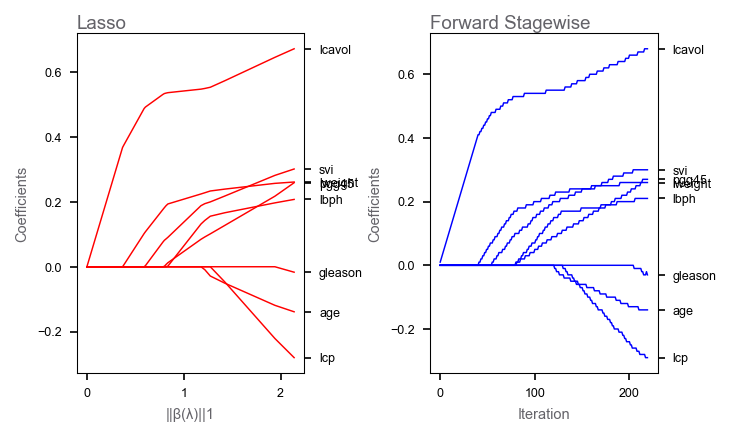

In [23]:
# PAGE 609. FIGURE 16.1. Profiles of estimated coefficients from linear
#           regression, for the prostate data studied in Chapter 3. The left
#           panel shows the results from the lasso, for different values of the
#           bound parameter t = SUMk|αk|. The right panel shows the results of
#           the stagewise linear regression Algorithm 16.1, using M = 220
#           consecutive steps of size ε = .01.
def plot_coef_profiles(ax, title, color, coef, x_values, x_title):
    for i in range(coef.shape[1]):
        ax.plot(x_values, coef[:, i], color=color, linewidth=0.7)
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    plt.setp(ax2, yticks=coef[-1], yticklabels=features)
    for i in ax.get_yticklabels() + ax.get_xticklabels() + \
             ax2.get_yticklabels():
        i.set_fontsize(6)
    ax.set_xlabel(x_title, color=GRAY4, fontsize=7)
    ax.set_ylabel('Coefficients', color=GRAY4, fontsize=7)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1]*1.02, title, color=GRAY4,
            fontsize=9)

fig, axarr = plt.subplots(1, 2, figsize=(5, 3), dpi=150)
plt.subplots_adjust(wspace=0.55)
plot_coef_profiles(axarr[0], 'Lasso', 'red', b_hat, b_pow, '||β(λ)||1')
plot_coef_profiles(axarr[1], 'Forward Stagewise', 'blue', a_hat, range(M),
                   'Iteration')